***AI Engineer - P10 - Réalisez une application de recommandation de contenu***

# Importation des modules

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.decomposition import PCA

from collections import defaultdict


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_squared_error, mean_absolute_error


from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from heapq import nlargest

# Fonctions

In [2]:
# Fonction pour récupérer et concaténer les fichiers de clicks
def load_clicks_data(directory):
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith("clicks_hour_") and f.endswith(".csv")]
    df_clicks = pd.concat([pd.read_csv(file) for file in all_files], ignore_index=True)
    return df_clicks

In [3]:
# Fonction générique pour l'AED et visualisation
def perform_aed(df, titre="Dataset"):
    print(f"--- {titre} : Informations Générales ---")
    print(f"Dimensions (lignes, colonnes) : {df.shape}")
    print("Colonnes et types de données :")
    print(df.dtypes)
    print("\nValeurs manquantes par colonne :")
    print(df.isnull().sum())
    print("\nExemple de données :")
    print(df.head())
    print("\n--- Vue Statistique ---")
    print(df.describe(include='all'))

    # Distribution des colonnes numériques
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if not numeric_cols.empty:
        df[numeric_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
        plt.suptitle(f"Distributions des colonnes numériques pour {titre}", fontsize=16)
        plt.show()

    # Analyse des colonnes catégoriques
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if df[col].nunique() <= 10:  # Pour éviter les graphiques surchargés pour les colonnes très diversifiées
            plt.figure(figsize=(10, 5))
            sns.countplot(data=df, x=col, order=df[col].value_counts().index)
            plt.title(f"Répartition des catégories pour {col} dans {titre}", fontsize=14)
            plt.xticks(rotation=45)
            plt.show()

    # Matrice de corrélation
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = df[numeric_cols].corr(method="spearman")
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Carte de corrélation pour {titre} (Spearman)", fontsize=16)
        plt.show()

In [4]:
# Fonction pour la création des noms des colonnes (pour le fichier embeddings)
def generate_column_names(num_columns):
    return [f"embedding{i+1}" for i in range(num_columns)]

# Chargement des données

In [5]:
df_articles = pd.read_csv(r"datas/articles_metadata.csv")

In [6]:
# Charger les fichiers de clicks
directory = "datas/clicks/"
df_clicks = load_clicks_data(directory)

In [7]:
embeddings_file = "datas/articles_embeddings.pickle"
# Charger les embeddings (Pickle)
with open(embeddings_file, 'rb') as f:
    embeddings_array = pickle.load(f)

# Analyse exploratoire des données

## Articles

In [8]:
df_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [9]:
df_articles = df_articles[["article_id", "category_id"]]
df_articles.head()

,article_id,category_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


--- Articles Metadata : Informations Générales ---
Dimensions (lignes, colonnes) : (364047, 2)
Colonnes et types de données :
article_id     int64
category_id    int64
dtype: object

Valeurs manquantes par colonne :
article_id     0
category_id    0
dtype: int64

Exemple de données :
   article_id  category_id
0           0            0
1           1            1
2           2            1
3           3            1
4           4            1

--- Vue Statistique ---
          article_id    category_id
count  364047.000000  364047.000000
mean   182023.000000     283.108239
std    105091.461061     136.723470
min         0.000000       0.000000
25%     91011.500000     199.000000
50%    182023.000000     301.000000
75%    273034.500000     399.000000
max    364046.000000     460.000000


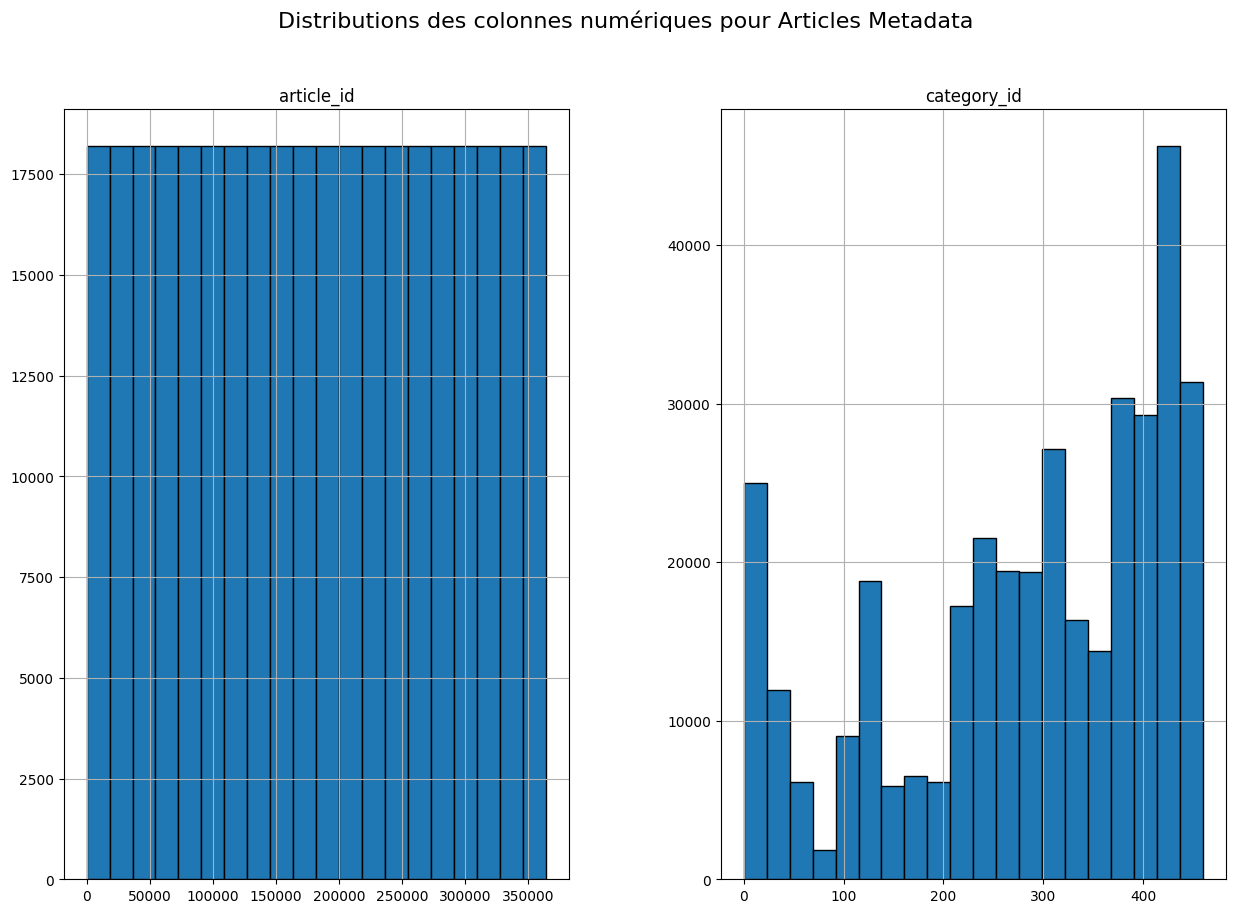

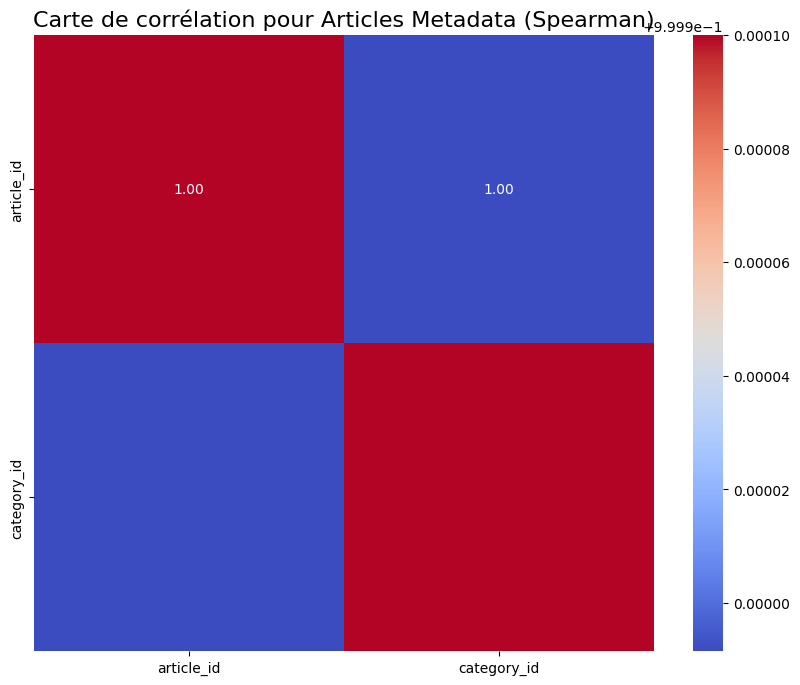

In [10]:
perform_aed(df_articles, titre="Articles Metadata")

## Clicks

In [11]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [12]:
df_clicks = df_clicks[["user_id", "session_id", "session_size", "click_article_id"]]
df_clicks.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [13]:
perform_aed(df_clicks, titre="Clicks Sample")

--- Clicks Sample : Informations Générales ---
Dimensions (lignes, colonnes) : (2988181, 4)
Colonnes et types de données :
user_id             object
session_id          object
session_size        object
click_article_id    object
dtype: object

Valeurs manquantes par colonne :
user_id             0
session_id          0
session_size        0
click_article_id    0
dtype: int64

Exemple de données :
  user_id        session_id session_size click_article_id
0       0  1506825423271737            2           157541
1       0  1506825423271737            2            68866
2       1  1506825426267738            2           235840
3       1  1506825426267738            2            96663
4       2  1506825435299739            2           119592

--- Vue Statistique ---
        user_id        session_id  session_size  click_article_id
count   2988181           2988181       2988181           2988181
unique   322897           1048594            72             46033
top        5890  1507563657

## Users

In [14]:
df_users = df_clicks.groupby("user_id").agg({"click_article_id":lambda x: list(x)})
df_users.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."


## Embeddings

In [15]:
embeddings_array

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [16]:
# Transformation en DataFrame
num_columns = embeddings_array.shape[1]
columns = generate_column_names(num_columns)
df_embeddings = pd.DataFrame(embeddings_array, columns=columns)

In [17]:
# Afficher le DataFrame
df_embeddings.head()

,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,embedding8,embedding9,embedding10,...,embedding241,embedding242,embedding243,embedding244,embedding245,embedding246,embedding247,embedding248,embedding249,embedding250
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


Il y a 250 embeddings. Actuellement le fichier fait 350Mo, il faut donc réduire sa taille en faisant une ACP, pour pouvoir l'utiliser par la suite sur le Cloud.

### ACP

In [18]:
# Réalisation de l'ACP pour conserver environ 97% de la variance
pca = PCA(n_components=0.97)
principal_components = pca.fit_transform(df_embeddings)

In [19]:
# Transformation en DataFrame
df_principal_components = pd.DataFrame(principal_components, 
                                       columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

In [20]:
df_principal_components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63
0,-2.176782,1.316913,-1.029048,0.901907,-1.809542,-2.064713,-1.221915,-0.024441,0.927260,-0.669806,...,0.332370,0.610106,-0.442540,-0.155501,-0.179364,0.393665,-0.222121,0.230562,-0.100259,0.048755
1,-1.735173,-0.489893,3.268562,0.087855,1.473059,-0.932711,1.841631,-0.881798,-0.207202,0.816809,...,-0.016993,-0.177867,-0.111825,-0.038613,0.167533,0.092189,-0.245874,-0.102162,0.083865,-0.035472
2,-0.912688,2.089339,1.865868,-1.202519,2.530601,-0.521970,0.224352,1.479936,-0.191900,1.356800,...,0.069820,-0.104514,0.204883,0.050820,-0.370875,0.186898,-0.019859,0.104982,0.102671,0.192432
3,1.096567,-0.212955,4.183517,-0.649575,-0.130867,1.126555,1.063997,-0.662875,0.348142,1.463899,...,0.066604,-0.483652,-0.314210,-0.159641,-0.129978,0.060362,0.244906,0.180050,-0.028684,-0.371259
4,0.193785,0.263949,1.896582,-1.834344,1.270378,-1.723296,0.329006,0.283794,-0.659808,1.223740,...,0.015988,-0.181448,0.009166,-0.165059,-0.091432,-0.059172,-0.186990,0.448666,-0.348881,0.222746


In [21]:
sum(pca.explained_variance_ratio_)

0.9709584579104558

On se retrouve avec maintenant 63 embeddings qui couvre 97% de la variance de nos données d'origine.

# Sauvegarde des fichiers

In [22]:
filepath = "azure_datas"

list_dir = os.listdir('datas/')

if filepath not in list_dir:
    os.mkdir('datas/' + filepath)

df_principal_components.to_pickle('datas/' + filepath + '/articles_embeddings.pickle')
df_clicks.to_pickle('datas/' + filepath + '/clicks.pickle')
df_users.to_pickle('datas/' + filepath + '/users.pickle')
df_articles.to_pickle('datas/' + filepath + '/articles.pickle')

In [23]:
# Récupérer les user_id uniques
unique_user_ids = df_clicks['user_id'].drop_duplicates().tolist()


# Sauvegarder dans un fichier texte
output_file = "datas/"+ filepath+ "/user_id.txt"
with open(output_file, "w") as file:
    file.write(f"{unique_user_ids}")

print(f"Les user_id uniques ont été sauvegardés dans le fichier {output_file}.")

Les user_id uniques ont été sauvegardés dans le fichier datas/azure_datas/user_id.txt.


Le fichier articles_embeddings.pickle fait maintenant 89Mo grâce à l'ACP.

# Modèles de recommandations de contenu

## Modèle type Content-Based Filtering

### Fonctions

In [24]:
# Fonction de filtrage basé sur le contenu
def content_based_filtering(embeddings, clicks, user_id, n=5):
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    if not articles_read:
        print(f"L'utilisateur {user_id} n'a lu aucun article.")
        return []

    articles_read_embedding = embeddings.loc[articles_read]
    articles = embeddings.drop(index=articles_read)

    matrix = cosine_similarity(articles_read_embedding, articles)

    rec = []

    for _ in range(n):
        coord_x, coord_y = divmod(np.argmax(matrix), matrix.shape[1])
        rec.append(int(embeddings.index[coord_y]))
        matrix[coord_x][coord_y] = 0

    rec.sort()

    return rec

### Tests du modèle

In [25]:
user_id_example = 1

In [26]:
recommendations = content_based_filtering(df_embeddings, df_clicks, user_id_example, n=5)
print(f"Recommandations finales pour l'utilisateur {user_id_example} : {recommendations}")

Recommandations finales pour l'utilisateur 1 : [228292, 228937, 233822, 235071, 345912]


In [27]:
recommendations = content_based_filtering(df_principal_components, df_clicks, user_id_example, n=5)
print(f"Recommandations finales pour l'utilisateur {user_id_example} : {recommendations}")

Recommandations finales pour l'utilisateur 1 : [228292, 228937, 233822, 235071, 345912]


In [28]:
user_id_example = 156

In [29]:
recommendations = content_based_filtering(df_embeddings, df_clicks, user_id_example, n=5)
print(f"Recommandations finales pour l'utilisateur {user_id_example} : {recommendations}")

Recommandations finales pour l'utilisateur 156 : [240738, 242071, 242194, 243049, 268523]


In [30]:
recommendations = content_based_filtering(df_principal_components, df_clicks, user_id_example, n=5)
print(f"Recommandations finales pour l'utilisateur {user_id_example} : {recommendations}")

Recommandations finales pour l'utilisateur 156 : [240738, 242071, 242194, 243049, 268523]


Le modèle repose sur le calcul de la similarité cosinus entre les articles déjà lus par l'utiilsateur et les autres articles disponibles. Ces articles sont représentés sous formes de vecteurs dans un espace vectoriel construit à partir de leurs caractéristiques dérivées de la matrice d'embeddings.

La recommandation retourne les n articles les plus similaires, où n=5 dans notre cas.

L'ajustement à 97% de la variance pour l'ACP nous permet d'avoir les mêmes résultats avec ou sans l'ACP.

## Modèle type Collaborative Filtering

### Fonctions

In [31]:
# Fonction de calcul des ratings basés sur les clics
def calcul_rating_by_clicks(clicks):
    count_user_article_size = clicks.groupby(['user_id', 'click_article_id']).agg(user_article_size=("session_size", "sum"))
    count_user_total_size = clicks.groupby(['user_id']).agg(user_total_size=("session_size", "sum"))

    ratings = count_user_article_size.join(count_user_total_size, on="user_id")
    ratings['rating'] = ratings['user_article_size'] / ratings['user_total_size']
    ratings['rating'] = ratings['rating'].astype(float)

    ratings = ratings.reset_index().drop(['user_article_size', 'user_total_size'], axis=1)
    ratings = ratings.rename(columns={'click_article_id': 'article_id'})

    return ratings

In [32]:
# Fonction de recommandation collaborative
def collaborative_filtering_recommendation(embeddings, clicks, user_id, n=5):
    available_articles = list(embeddings.index)
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    for article in articles_read:
        if article in available_articles:
            available_articles.remove(article)

    predictions = {}

    for article_id in available_articles:
        pred = model_SVD.predict(user_id, article_id)
        predictions[article_id] = pred.est

    recommended_articles = nlargest(n, predictions, key=predictions.get)

    recommended_articles.sort()
    
    return recommended_articles

### Recherche des meilleurs hyperparamètres

In [33]:
df_ratings = calcul_rating_by_clicks(df_clicks)
df_ratings.head()

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125


In [34]:
df_ratings.to_pickle('datas/' + filepath + '/ratings.pickle')

--- Ratings : Informations Générales ---
Dimensions (lignes, colonnes) : (2950710, 3)
Colonnes et types de données :
user_id         int64
article_id      int64
rating        float64
dtype: object

Valeurs manquantes par colonne :
user_id       0
article_id    0
rating        0
dtype: int64

Exemple de données :
   user_id  article_id  rating
0        0       68866   0.125
1        0       87205   0.125
2        0       87224   0.125
3        0       96755   0.125
4        0      157541   0.125

--- Vue Statistique ---
            user_id    article_id        rating
count  2.950710e+06  2.950710e+06  2.950710e+06
mean   1.083921e+05  1.950297e+05  1.094303e-01
std    8.372895e+04  9.083343e+04  1.305946e-01
min    0.000000e+00  3.000000e+00  4.940589e-05
25%    4.072000e+04  1.242280e+05  2.450980e-02
50%    8.683000e+04  2.023880e+05  5.769231e-02
75%    1.639750e+05  2.770680e+05  1.363636e-01
max    3.228960e+05  3.640460e+05  5.000000e-01


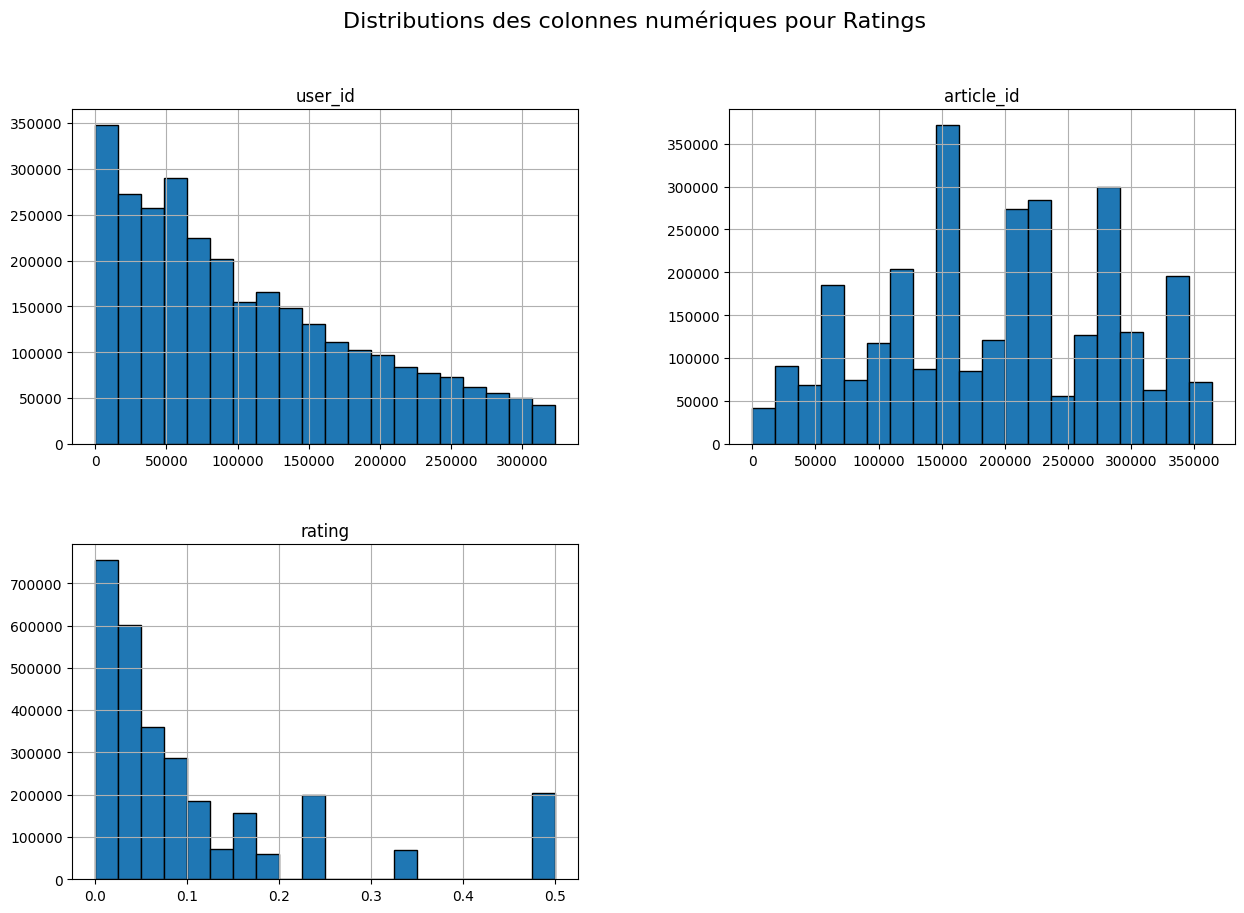

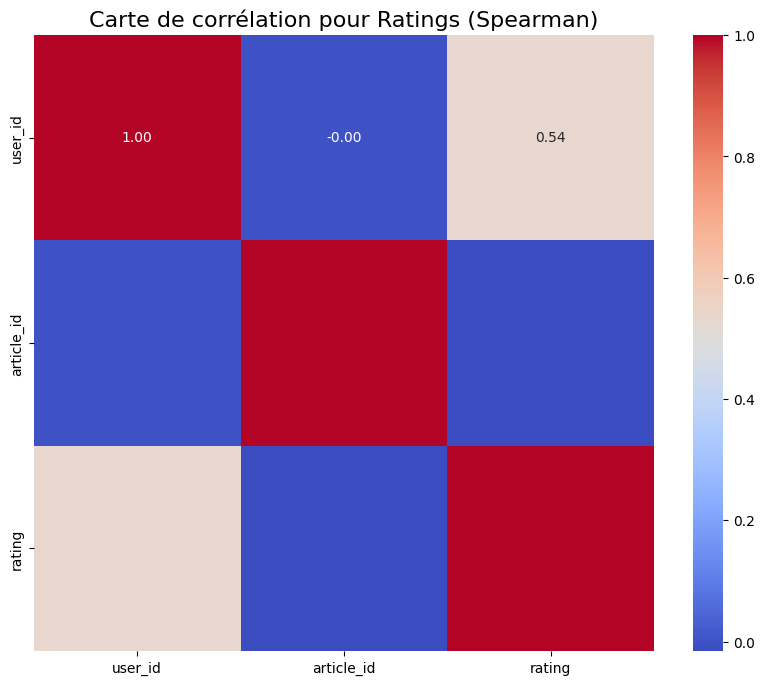

In [35]:
perform_aed(df_ratings, titre="Ratings")

In [36]:
# Hyperparamètres pour SVD
reader = Reader(rating_scale=(0, 1))
data_sample = Dataset.load_from_df(df_ratings.sample(frac=0.1, random_state=42), reader=reader)

param_grid = {
    'n_factors': [20, 50, 100], 
    'n_epochs': [10, 20, 50],
    'lr_all': [0.002, 0.005, 0.01], 
    'reg_all': [0.02, 0.04, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data_sample)

In [37]:
# Meilleurs paramètres et score
print("Meilleur score RMSE:", gs.best_score['rmse'])
print("Meilleurs paramètres:", gs.best_params['rmse'])

Meilleur score RMSE: 0.11408309071020191
Meilleurs paramètres: {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [38]:
# Modèle final basé sur les meilleurs paramètres
data_full = Dataset.load_from_df(df_ratings, reader=reader)
trainset = data_full.build_full_trainset()
model_SVD = gs.best_estimator['rmse']
model_SVD.fit(trainset)

In [39]:
# Sauvegarder le modèle entraîné
with open('datas/' + filepath +'/model_SVD.pkl', 'wb') as file:
    pickle.dump(model_SVD, file)

### Tests du modèle

In [40]:
user_id_example = 1

In [41]:
test_recommendations = collaborative_filtering_recommendation(df_embeddings, df_clicks, user_id=user_id_example, n=5)
print("Recommandations collaboratives pour l'utilisateur {user_id_example} :", test_recommendations)

Recommandations collaboratives pour l'utilisateur {user_id_example} : [74501, 100791, 186070, 283009, 289003]


In [42]:
user_id_example = 5

In [43]:
test_recommendations = collaborative_filtering_recommendation(df_embeddings, df_clicks, user_id=user_id_example, n=5)
print("Recommandations collaboratives pour l'utilisateur {user_id_example} :", test_recommendations)

Recommandations collaboratives pour l'utilisateur {user_id_example} : [36162, 39894, 50644, 289003, 352979]


In [44]:
user_id_example = 156

In [45]:
test_recommendations = collaborative_filtering_recommendation(df_embeddings, df_clicks, user_id=user_id_example, n=5)
print("Recommandations collaboratives pour l'utilisateur {user_id_example} :", test_recommendations)

Recommandations collaboratives pour l'utilisateur {user_id_example} : [39894, 50644, 277107, 283009, 289003]


In [46]:
user_id_example = 850

In [47]:
test_recommendations = collaborative_filtering_recommendation(df_embeddings, df_clicks, user_id=user_id_example, n=5)
print("Recommandations collaboratives pour l'utilisateur {user_id_example} :", test_recommendations)

Recommandations collaboratives pour l'utilisateur {user_id_example} : [39894, 50644, 74501, 277107, 283009]


In [48]:
user_id_example = 12430

In [49]:
test_recommendations = collaborative_filtering_recommendation(df_embeddings, df_clicks, user_id=user_id_example, n=5)
print("Recommandations collaboratives pour l'utilisateur {user_id_example} :", test_recommendations)

Recommandations collaboratives pour l'utilisateur {user_id_example} : [47324, 57790, 62066, 74884, 186070]


Les articles 74450, 74455, 289003 et 283009 ont été recommandés plusieurs fois.

In [50]:
nb_clicks = df_clicks.groupby('click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
nb_clicks = nb_clicks.head(50)

<Axes: xlabel='click_article_id'>

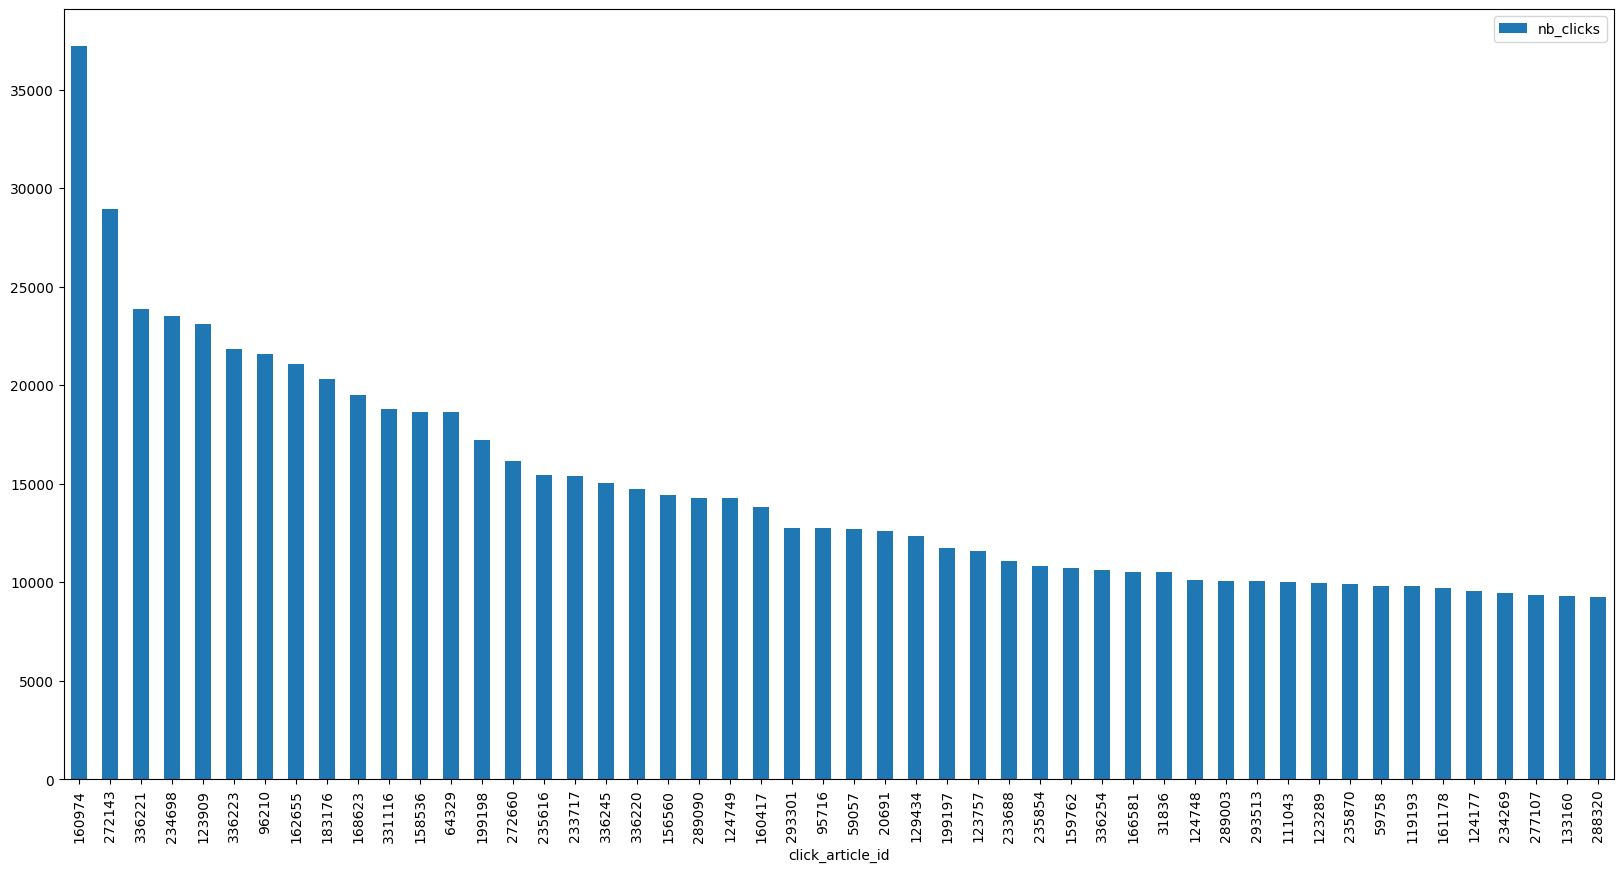

In [51]:
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20, 10))

Les articles fréquemment recommandés sont souvent ceux qui ont été cliqués par un grand nombre d'utilisateurs.

# Comparaison des modèles

## Fonctions

In [52]:
def calculate_metrics(true_ratings, predicted_ratings, verbose=1, k=5):
    """Calcul des métriques pour évaluer les modèles."""
    # RMSE et MAE
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)

    # Reshape des données pour nDCG@k
    true_ratings_2d = np.array([true_ratings])
    predicted_ratings_2d = np.array([predicted_ratings])

    # nDCG@k
    ndcg_at_k = ndcg_score(true_ratings_2d, predicted_ratings_2d, k=k)

    # Precision@k et Recall@k
    precision_at_k = sum(predicted_ratings[:k]) / k
    recall_at_k = sum(predicted_ratings[:k]) / sum(true_ratings)

    if verbose == 1:
        print(f"Metrics (k={k}):")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Precision@{k}: {precision_at_k:.4f}")
        print(f"Recall@{k}: {recall_at_k:.4f}")
        print(f"nDCG@{k}: {ndcg_at_k:.4f}")
    return rmse, mae, precision_at_k, recall_at_k, ndcg_at_k


## Calculs des métriques

### Test 1

In [53]:
# Extraire les notes réelles pour un utilisateur donné
user_id_example = 1
true_ratings = df_ratings[df_ratings['user_id'] == user_id_example]['rating'].values
articles_rated = df_ratings[df_ratings['user_id'] == user_id_example]['article_id'].values

In [54]:
predicted_ratings_cb = []
for article_id in articles_rated:
    similarity_scores = cosine_similarity(
        df_embeddings.loc[[article_id]].values,
        df_embeddings.values
    )
    predicted_ratings_cb.append(similarity_scores.mean())  # Exemple de score moyen

In [55]:
predicted_ratings_cf = []
for article_id in articles_rated:
    pred = model_SVD.predict(user_id_example, article_id)
    predicted_ratings_cf.append(pred.est)

In [56]:
# Calcul des métriques pour Content-Based Filtering
print("Content-Based Filtering Metrics:")
calculate_metrics(true_ratings, predicted_ratings_cb, k=5)

Content-Based Filtering Metrics:
Metrics (k=5):
RMSE: 0.1266
MAE: 0.1233
Precision@5: 0.1893
Recall@5: 0.9467
nDCG@5: 1.0000


(0.12661708948037928,
 0.12329727162917459,
 0.1893395185470581,
 0.9466975927352905,
 0.9999999999999999)

In [57]:
# Calcul des métriques pour Collaborative Filtering
print("Collaborative Filtering Metrics:")
calculate_metrics(true_ratings, predicted_ratings_cf, k=5)

Collaborative Filtering Metrics:
Metrics (k=5):
RMSE: 0.0547
MAE: 0.0390
Precision@5: 0.0822
Recall@5: 0.4111
nDCG@5: 1.0000


(0.05470682072579037,
 0.038967273303654015,
 0.08222999412009964,
 0.4111499706004982,
 0.9999999999999999)

### Test 2

In [58]:
# Extraire les notes réelles pour un utilisateur donné
user_id_example = 25647
true_ratings = df_ratings[df_ratings['user_id'] == user_id_example]['rating'].values
articles_rated = df_ratings[df_ratings['user_id'] == user_id_example]['article_id'].values

In [59]:
predicted_ratings_cb = []
for article_id in articles_rated:
    similarity_scores = cosine_similarity(
        df_embeddings.loc[[article_id]].values,
        df_embeddings.values
    )
    predicted_ratings_cb.append(similarity_scores.mean())  # Exemple de score moyen

In [60]:
predicted_ratings_cf = []
for article_id in articles_rated:
    pred = model_SVD.predict(user_id_example, article_id)
    predicted_ratings_cf.append(pred.est)

In [61]:
# Calcul des métriques pour Content-Based Filtering
print("Content-Based Filtering Metrics:")
calculate_metrics(true_ratings, predicted_ratings_cb, k=5)

Content-Based Filtering Metrics:
Metrics (k=5):
RMSE: 0.1673
MAE: 0.1623
Precision@5: 0.1957
Recall@5: 0.9783
nDCG@5: 0.3933


(0.16728568083602027,
 0.16226809697620795,
 0.19565165042877197,
 0.9782582521438599,
 0.3933424357628723)

In [62]:
print(f"Taille de true_ratings : {len(true_ratings)}")
print(f"Taille de predicted_ratings_cf : {len(predicted_ratings_cf)}")

Taille de true_ratings : 33
Taille de predicted_ratings_cf : 33


In [63]:
min_length = min(len(true_ratings), len(predicted_ratings_cf))
true_ratings = true_ratings[:min_length]
predicted_ratings_cf = predicted_ratings_cf[:min_length]

In [64]:
# Calcul des métriques pour Collaborative Filtering
print("Collaborative Filtering Metrics:")
calculate_metrics(true_ratings, predicted_ratings_cf, k=5)

Collaborative Filtering Metrics:
Metrics (k=5):
RMSE: 0.1217
MAE: 0.1078
Precision@5: 0.1467
Recall@5: 0.7337
nDCG@5: 0.3333


(0.1216716109192243,
 0.10784043281176559,
 0.14674695769782237,
 0.7337347884891118,
 0.3333333333333333)

### Visualisations graphiques

In [65]:
# Initialiser des structures pour stocker les métriques
metrics_cb = defaultdict(list)
metrics_cf = defaultdict(list)

In [66]:
# Liste des utilisateurs
user_ids = df_ratings['user_id'].unique()

In [67]:
# Taille de la liste des utilisateurs uniques
user_count = len(user_ids)
print(f"Nombre d'utilisateurs uniques : {user_count}")

Nombre d'utilisateurs uniques : 322897


In [68]:
# Définir la taille de l'échantillon (par exemple, 500 utilisateurs)
sample_size = 1000

# Prendre un échantillon aléatoire d'utilisateurs
sample_user_ids = np.random.choice(user_ids, size=sample_size, replace=False)

print(f"Nombre d'utilisateurs dans l'échantillon : {len(sample_user_ids)}")

Nombre d'utilisateurs dans l'échantillon : 1000


In [69]:
for user_id in sample_user_ids:
    # Notes réelles et articles pour l'utilisateur
    true_ratings = df_ratings[df_ratings['user_id'] == user_id]['rating'].values
    articles_rated = df_ratings[df_ratings['user_id'] == user_id]['article_id'].values

    # Prédictions pour Content-Based Filtering
    predicted_ratings_cb = []
    for article_id in articles_rated:
        similarity_scores = cosine_similarity(
            df_embeddings.loc[[article_id]].values,
            df_embeddings.values
        )
        predicted_ratings_cb.append(similarity_scores.mean())  # Exemple de score moyen

    # Prédictions pour Collaborative Filtering
    predicted_ratings_cf = []
    for article_id in articles_rated:
        pred = model_SVD.predict(user_id, article_id)
        predicted_ratings_cf.append(pred.est)

    # Calcul des métriques pour Content-Based Filtering
    rmse, mae, precision, recall, ndcg = calculate_metrics(true_ratings, predicted_ratings_cb, verbose=0, k=5)
    metrics_cb['RMSE'].append(rmse)
    metrics_cb['MAE'].append(mae)
    metrics_cb['Precision@5'].append(precision)
    metrics_cb['Recall@5'].append(recall)
    metrics_cb['nDCG@5'].append(ndcg)

    # Calcul des métriques pour Collaborative Filtering
    rmse, mae, precision, recall, ndcg = calculate_metrics(true_ratings, predicted_ratings_cf, verbose=0, k=5)
    metrics_cf['RMSE'].append(rmse)
    metrics_cf['MAE'].append(mae)
    metrics_cf['Precision@5'].append(precision)
    metrics_cf['Recall@5'].append(recall)
    metrics_cf['nDCG@5'].append(ndcg)

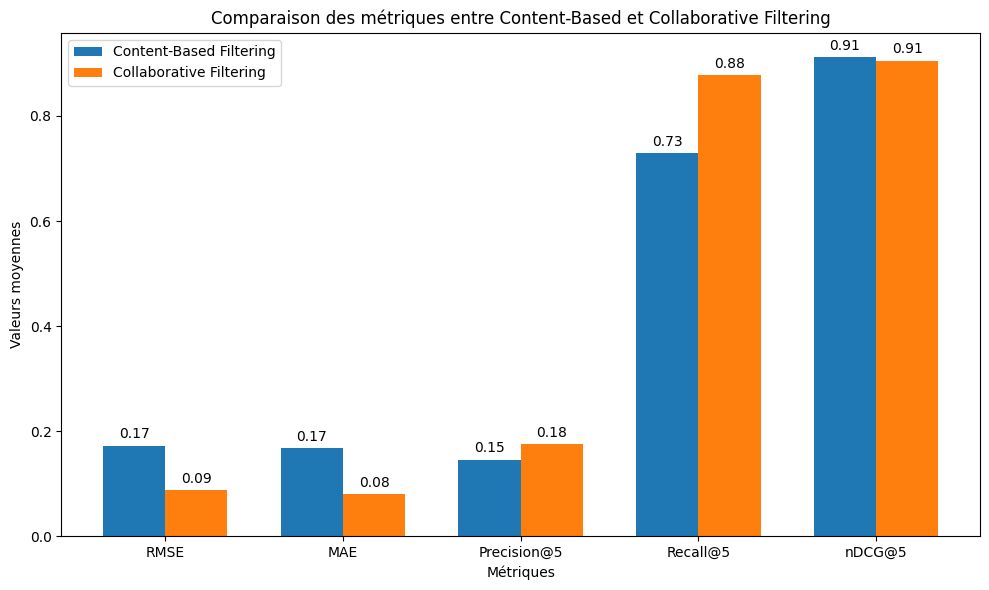

In [70]:
# Moyennes des métriques pour chaque méthode
metrics = ['RMSE', 'MAE', 'Precision@5', 'Recall@5', 'nDCG@5']
cb_means = [np.mean(metrics_cb[metric]) for metric in metrics]
cf_means = [np.mean(metrics_cf[metric]) for metric in metrics]

# Tracer les comparaisons
x = np.arange(len(metrics))  # Indices des métriques
width = 0.35  # Largeur des barres

fig, ax = plt.subplots(figsize=(10, 6))
bars_cb = ax.bar(x - width/2, cb_means, width, label='Content-Based Filtering')
bars_cf = ax.bar(x + width/2, cf_means, width, label='Collaborative Filtering')

# Ajouter des labels et un titre
ax.set_xlabel('Métriques')
ax.set_ylabel('Valeurs moyennes')
ax.set_title('Comparaison des métriques entre Content-Based et Collaborative Filtering')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Afficher les valeurs sur les barres
for bars in [bars_cb, bars_cf]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Décalage
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Conclusion

Le Collaborative Filtering semble globalement meilleur, car il a de meilleures performances en termes de RMSE et MAE, indiquant une plus grande précision pour les prédictions.

Le Content-Based Filtering a un léger avantage en termes de rappel, ce qui signifie qu'il capture mieux une plus grande proportion des articles pertinents dans ses recommandations.

Les deux modèles sont comparables en termes de nDCG@5 et Precision@5, ce qui montre qu'ils ordonnent les recommandations de manière similaire.